1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

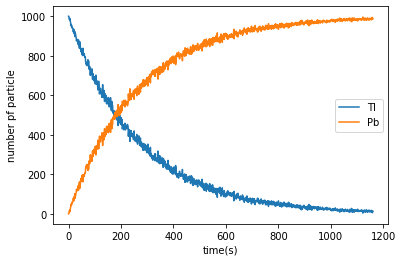

In [29]:
import numpy as np
import numpy.random as npr
import time
import matplotlib.pyplot as plt

npr.seed(int(time.time()))

N0=1000
t_h = 3.052 * 60 #seconds

Pb = []
Tl = []
Tl.append(N0) #at t=0 all the particle are Tl
Pb.append(0)
# per ogni istante definisco un nuovo set di numeri che sono le probabilità i-esime di 
# una particella di decadere. Questo numero va confrontato con la probabilità di decaredere al tempo t.
# se la probabilità di sopravvivenza è maggiore allora la particella sopravvive altrimenti la p decade e va tolta 
t0 = 0
tf = 6.345 * t_h
t = range(t0 , int(tf)) # tempo in cui voglio osservare le particelle

for ti in t[1:]: #per ogni istante da 1 sec in poi!
    n = npr.rand(N0)
    Prob = 1 - 2**(-ti/t_h) #prob di sopravvivere
    Tl.append(N0 - len(n[n < Prob])) #tolgo le particelle con prob di sopravvivere
    Pb.append(len(n[n < Prob]))

fig, ax = plt.subplots()
ax.plot(t, Tl, label="Tl")
ax.plot(t, Pb, label="Pb")
ax.set_xlabel('time(s)')
ax.set_ylabel('number pf particle')
ax.legend()


INVERSE TRASFORM METHOD 

* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time


Text(0, 0.5, 'number pf particle')

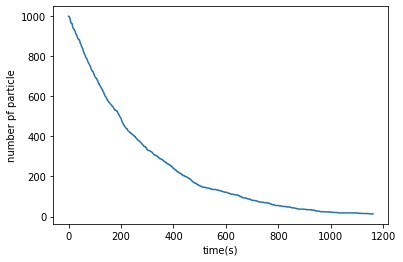

In [45]:
def expon_icdf(z, mu=np.log(2)/t_h):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-z)/mu

#generare 1000 numeri random seconda la unif. distr.
x = npr.uniform(0,1, N0)
y = expon_icdf(x) #tempo di decadimento di ogni particella

Tl = []
Tl.append(N0)

for ti in t[1:]:
    Tl.append(N0 - len(y[y < ti]))
fig, ax = plt.subplots()
ax.plot(t, Tl)
ax.set_xlabel('time(s)')
ax.set_ylabel('number pf particle')

    


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [25]:
import pandas as pd
from scipy import constants
e = constants.elementary_charge
alfa = 5.291777721092 * 10**-11
e_0 = constants.epsilon_0
E = 7.7E6 *e
Z=79
sigma = alfa / 100 

def theta(b):
    return 2*np.arctan(Z*e**2 / (2*np.pi *e_0*E*b) )

N = 1000000
cov_matrix = sigma*np.eye(2)
mu = 0
x = np.random.normal(mu, sigma, N)
y = np.random.normal(mu, sigma, N)

# beam = np.random.multivariate_normal(mu, cov_matrix, N).T
b = np.sqrt( x**2 + y**2)
scatt = theta(b)
back_scatt = scatt[scatt> np.pi/2]

print("The number of back scattered particle are",len(back_scatt))
print("the fraction of them is", len(back_scatt)/N, "that corresponds to", len(back_scatt)/N *100, "%")

The number of back scattered particle are 1560
the fraction of them is 0.00156 that corresponds to 0.156 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

the integral with error:1.451340 \pm 0.002822
the integral with error:1.448308 \pm 0.001672


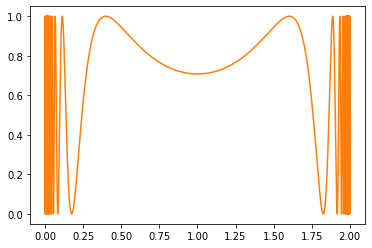

In [47]:
from scipy import random
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return (np.sin(1/(x*(2-x))))**2

#hit/miss method
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
p=count/N
err = 2*np.sqrt(N*p*(1-p))/N
print("the integral with error:%3.6f \pm %3.6f" %(I,err))

#mean value method
a=0
b=2 #limit of integation
N=100000
x = random.uniform(a,b,N)
I=0
for i in range(N):
    I += f(x[i])
A = (b-a)/N * I
err = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)
print("the integral with error:%3.6f \pm %3.6f" %(A,err) )

x = np.linspace(0.001, 1.999, N)
plt.plot(x,f(x),'C1')

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [52]:
def f(x):
    r_sq = np.sum(x**2 , axis=0)
    return np.array([1 if (r <= 1) else 0 for r in r_sq])

#2D

N = 1000000
x = np.random.uniform(-1,1,(2,N))
I = 2**2*np.sum(f(x))/N
err = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)

print("the integral with error:%3.6f \pm %3.6f" %(I,err) )

#10D

x = np.random.uniform(-1,1,(10,N))
I = 2**10*np.sum(f(x))/N
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)

print("The area of the unit radius circle in 10D is %3.6f +- %3.6f"%(I, err))


the integral with error:3.141584 \pm 0.000821
The area of the unit radius circle in 10D is 2.468864 +- 0.000821


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [55]:
def w(x):
    return 1/(np.sqrt(x))

def f(x):
    return (x**(-1/2) / (np.exp(x) +1))

N = int(1e4)
x = np.random.rand(N)**2

I = (2/N)*np.sum(f(x)/w(x))

print("The value of the Integral of f(x) is %3.6f" %I)

The value of the Integral of f(x) is 0.837244
